In [1]:
from langchain_community.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(
    file_path="jobs.csv"
)
data = loader.load()
from langchain_openai.chat_models.base import ChatOpenAI

from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,BaseMessage
llm = ChatOpenAI(
            base_url="http://localhost:1234/v1",
            api_key="not_needed",
            model="gemma-2-27b-it"
        )

In [2]:
from typing import Any
from langchain.tools import BaseTool
import chromadb
from chromadb.config import Settings
from pydantic import Field, PrivateAttr

class ChromaDBTool(BaseTool):
    name: str = "ChromaDBTool"
    description: str = (
        "A tool that interfaces with a ChromaDB database to retrieve information. "
        "It initializes a connection to a specified collection and runs queries against it."
    )
    collection_name: str = Field(default="default_collection")
    persist_directory: str = Field(default="./chroma_db")

    # Declare private attributes for runtime-only properties.
    _client: Any = PrivateAttr()
    _collection: Any = PrivateAttr()

    def __init__(self):
        super().__init__()
        self._client = chromadb.Client(Settings(persist_directory=self.persist_directory))
        try:
            self._collection = self._client.get_collection(name=self.collection_name)
        except Exception as e:
            self._collection = self._client.create_collection(name=self.collection_name)
      
    def add_document(self, document: str, id: str):
        """
        Add a document to the ChromaDB collection.
        """
        try:
            self._collection.add(documents=[document], ids=[id])
            return "Document added successfully."
        except Exception as e:
            return f"Error adding document: {e}"
    def add_documents(self, documents: list, ids: list):
        """
        Add multiple documents to the ChromaDB collection.
        """
        try:
            self._collection.add(documents=documents, ids=ids)
            return "Documents added successfully."
        except Exception as e:
            return f"Error adding documents: {e}"
    def _run(self, query: str, **kwargs):
        print("chromadb")
        """
        Synchronous method to query the ChromaDB collection.
        Expects a text query and returns the query results.
        """
        try:
            results = self._collection.query(query_texts=[query],n_results=2)
            return list(zip(results["documents"][0],results["distances"][0]))
        except Exception as e:
            return f"Error querying the database: {e}"

    async def _arun(self, query: str, **kwargs):
        """
        Asynchronous version of the _run method.
        Currently, this calls the synchronous version for simplicity.
        """
        return self._run(query, **kwargs)
tool = ChromaDBTool()
tool.add_documents([d.page_content for d in data], [str(i) for i in range(len(data))])

'Documents added successfully.'

In [3]:
tool.invoke("Java")

chromadb


[("type: contract\ncompany: Somos Feed\nlocation: Argentina\nrole: Data Architect\nstart_date: 01/07/2024\nend_date: 01/12/2024\ndescription: Python, Django, Javascript, SQLite. Designed and built the backend infrastructure on Django for the company to automate the process of data gathering from all its different providers. Generated the ETL pipeline to load the information onto the database from google sheet files and created the machine learning algorithm to be trained weekly on the previous week's data to estimate sales and reduce waste, genrating up to a 68% of waste reduction and increasing the benefits of the company by 30%. The solutiopn also freed time of other data scientists in the team that were previously just cleaning data.",
  1.5428789854049683),
 ('type: non-profit\ncompany: CEITBA\nlocation: Argentina\nrole: Lead Developer\nstart_date: 01/03/2021\nend_date: 01/03/2025\ndescription: Python, Javascript, React, Dart, Flutter. Led a team of five in developing a Flutter-bas

In [4]:

llm_with_tools = llm.bind_tools([tool])

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

def chatbot(state: State):
    print('chatbot message')
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
import json

from langchain_core.messages import ToolMessage




class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print('tools message')
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            print(tool_call["args"])
            tool_result = self.tools_by_name["ChromaDBTool"].invoke(
                tool_call["args"]
            )
            print(tool_result)
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])

graph_builder.add_node("tools", tool_node)

In [7]:
tool_node.tools_by_name

{'ChromaDBTool': ChromaDBTool()}

In [8]:
def route_tools(
        state:State
):
    if isinstance(state, list):
        message = state[-1]
    elif messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError("No message found in input")
    if hasattr(message, "tool_calls") and len(message.tool_calls) > 0:
        return "tools"
    return END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route_tools ,{"tools": "tools", END: END})
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

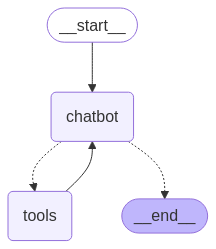

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
PROMPT = """You are BetterResume, an open-source tool that helps users create the best possible resumes optimized for ATS AI scanners.  

The user has granted you access to their full job experience, which is stored in a vector database. You can retrieve relevant information from this database by calling `ChromaDBTool` with the argument `query: str`. This will return the most relevant job experience for inclusion in the resume.  

**Instructions:**  
1. **Make at least one call to `ChromaDBTool`** to retrieve relevant experience.  
2. **Make multiple tool calls (at least 4!) according to the different skills asked for in the description** to gather more data.  
3. **Wait for the tool's response(s), then format and return the information as a structured JSON object.**  
4. **Extract skills, languages, and technologies ONLY if they are explicitly mentioned in the retrieved job descriptions.**  
5. **Include at least 3 experiences in the resume output.** It doesnt have to be a job, can be other stuf like contract, volunteer, etc.
6. **Ensure the output follows this JSON format:**  

```json
{
  "resume_section": {
    "title": "Title describing the job that the user is applying for",
    "experience": [
      {
        "position": "Job Title",
        "company": "Company Name",
        "location": "Location",
        "start_date": "Month Year",
        "end_date": "Month Year or Present",
        "description": "Detailed job description and achievements."
      }
    ],
    "skills": {
      "languages": ["List of programming languages"],
      "databases": ["List of databases"],
      "tools_and_technologies": ["List of tools, frameworks, and methodologies"]
    }
  }
}
```
Do not include additional text, explanations, or formatting outside of the JSON output.

Do not include languages that are not implied by the database query.

Ensure consistency in date formatting and job descriptions to maintain a professional resume output.

If you understand, proceed with handling the user request.
"""

JOB_PROMPT = """About the job
Job Description: Azure & SQL Data Engineer

 

As a Data Engineer, you will be responsible for designing, implementing, and maintaining data solutions with a strong focus on SQL databases. You will collaborate with cross-functional teams to gather requirements, design efficient and robust SQL queries, and ensure data integrity and security.

 

Responsibilities:



· Collaborate with stakeholders to gather data requirements and translate them into technical specifications.

· Build and optimize SQL queries for data ingestion, transformation, and storage.

· Utilize Azure Data Factory for data orchestration and workflow automation.

· Monitor and troubleshoot SQL databases to ensure performance and availability.

· Work closely with data scientists and analysts to support their data needs through optimized SQL queries and reporting tools.

· Stay up-to-date with the latest trends and advancements in SQL data engineering and recommend best practices to enhance data solutions.

 

Qualifications:



· 3+ years of proven experience as a data engineer with a strong focus on SQL.

· Strong expertise in C#, SQL and extensive experience with data modeling and database design.

· Excellent problem-solving and analytical skills.

· Knowledge of data governance and data security principles.

· Strong communication and collaboration abilities.

· It is desired familiarity with Power Apps.

· Ideally, but not mandatory, familiarity with Azure data services such as Azure SQL Database, Azure Data Factory, etc."""

response = graph.invoke({"messages": [{"role": "system", "content": PROMPT},
                           {"role": "user", "content": JOB_PROMPT}]})

chatbot message
tools message
{'query': 'SQL database design experience'}
chromadb
[('type: job\ncompany: Accenture\nlocation: Argentina\nrole: Data Engineer\nstart_date: 01/08/2024\nend_date: \ndescription: Python, SQL, Javascript, Google sheets. Developed and integrated AI-driven solutions for a large bank, utilizing LangChain and RAGs to enhance LLM capabilities. Implemented voice message processing and structured data queries, improving system response accuracy. Collaborated in Agile sprints, contributing to increased system efficiency and performance. Used Data scraping techniques to gather information for my vector database (chromaDB) and deployed it on Azure using github actions with testing and CI/CD to ensure consistency on the product. Also worked on ETL pipelines to upload and generate a system to detect anomalies in the machine in order to prevent sudden breakdowns', 1.4754233360290527), ('type: job\ncompany: Turbodato\nlocation: Argentina\nrole: Data Architect\nstart_date:

In [11]:
text = response["messages"][-1].content

from IPython.display import Markdown
Markdown(text)

```json
{
  "resume_section": {
    "title": "Azure & SQL Data Engineer",
    "experience": [
      {
        "position": "Data Engineer",
        "company": "Accenture",
        "location": "Argentina",
        "start_date": "01/08/2024",
        "end_date": "Present",
        "description": "Developed and integrated AI-driven solutions for a large bank, utilizing LangChain and RAGs to enhance LLM capabilities. Implemented voice message processing and structured data queries, improving system response accuracy. Collaborated in Agile sprints, contributing to increased system efficiency and performance. Used Data scraping techniques to gather information for my vector database (chromaDB) and deployed it on Azure using github actions with testing and CI/CD to ensure consistency on the product. Also worked on ETL pipelines to upload and generate a system to detect anomalies in the machine in order to prevent sudden breakdowns"
      },
      {
        "position": "Data Architect",
        "company": "Turbodato",
        "location": "Argentina",
        "start_date": "01/01/2024",
        "end_date": "01/12/2024",
        "description": "Designed and built the startup’s backend infrastructure with a focus on scalability and automation. Developed web scraping bots to collect competitive business intelligence for clients like Itaú Bank and Cebra Jugueterías. Created interactive dashboards using Power BI, enabling real-time decision-making."
      },
      {
        "position": "Lead Developer",
        "company": "CEITBA",
        "location": "Argentina",
        "start_date": "01/03/2021",
        "end_date": "01/03/2025",
        "description": "Led a team of five in developing a Flutter-based mobile application for CEITBA, utilizing Firebase and Google Cloud for scalability. Automated administrative tasks with AI-based tools, optimizing student registrations, withdrawals, and query responses."
      }

    ],
    "skills": {
      "languages": ["Python", "Javascript", "SQL"],
      "databases": ["Azure SQL Database", "SQLite"],
      "tools_and_technologies": ["LangChain", "RAGs","Power BI","Flutter","Firebase","Google Cloud","Django","chromaDB", "github actions","CI/CD"]
    }
  }
}
```

In [12]:
response


{'messages': [SystemMessage(content='You are BetterResume, an open-source tool that helps users create the best possible resumes optimized for ATS AI scanners.  \n\nThe user has granted you access to their full job experience, which is stored in a vector database. You can retrieve relevant information from this database by calling `ChromaDBTool` with the argument `query: str`. This will return the most relevant job experience for inclusion in the resume.  \n\n**Instructions:**  \n1. **Make at least one call to `ChromaDBTool`** to retrieve relevant experience.  \n2. **Make multiple tool calls (at least 4!) according to the different skills asked for in the description** to gather more data.  \n3. **Wait for the tool\'s response(s), then format and return the information as a structured JSON object.**  \n4. **Extract skills, languages, and technologies ONLY if they are explicitly mentioned in the retrieved job descriptions.**  \n5. **Include at least 3 experiences in the resume output.**